In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

# 2. Load the breast cancer dataset
data = pd.read_csv("breast_cancer.csv")

# View the first few rows to understand column names
print(data.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [2]:
# Encode the diagnosis column: M = 0 (malignant), B = 1 (benign)
data['diagnosis'] = data['diagnosis'].map({'M': 0, 'B': 1})

# Drop non-numeric or identifier columns if needed
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
    # 5. Train Linear SVM
linear_svm = SVC(kernel='linear', C=1)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))

Linear SVM Accuracy: 0.956140350877193
Confusion Matrix:
 [[41  2]
 [ 3 68]]


In [5]:
# 6. Train RBF SVM with default parameters
rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)

print("\nRBF SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))


RBF SVM Accuracy: 0.9736842105263158
Confusion Matrix:
 [[41  2]
 [ 1 70]]


In [6]:
# 7. Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("\nBest Parameters from GridSearch:", grid.best_params_)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Accuracy after Tuning:", accuracy_score(y_test, y_pred_best))


Best Parameters from GridSearch: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy after Tuning: 0.9824561403508771


In [7]:
# 8. Cross-validation score
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.97368421 0.97368421 0.98245614 0.97368421 0.99115044]
Mean CV Accuracy: 0.9789318428815401


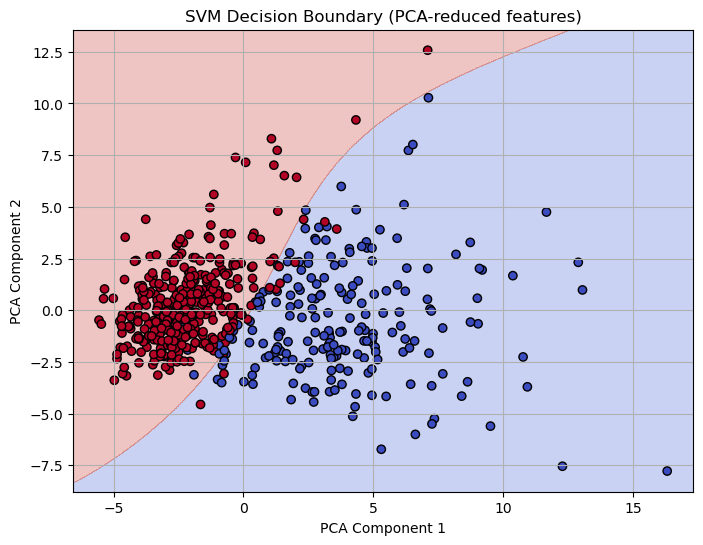

In [8]:
# 9. Visualize decision boundary using PCA (reduce to 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train SVM again on PCA-transformed data for visualization
svm_vis = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svm_vis.fit(X_pca, y)

# Plot decision boundary
def plot_svm_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

plot_svm_decision_boundary(svm_vis, X_pca, y, "SVM Decision Boundary (PCA-reduced features)")